# Stim and LFP phase
## How well is the system detecting target LFP phases?

### Needs emk_neuro_analysis environment
### load LFP, DIO and time data

In [130]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools
from scipy.signal import sosfiltfilt, butter, hilbert
from scipy.stats import circstd
from scipy import stats

from emk_analysis import builder_experiment as bld_exp
# from emk_neuro_analysis.align import align_to_events_continuous
from emk_neuro_analysis.lfp import iterator as lfp_iter
from emk_neuro_analysis.position import iterator as pos_iter
from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter
import pywt

from scipy import signal
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

### Experiment parameters

In [131]:
# name of experiment
experiment_name = '6082737'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme0'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
# fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config_laser.xlsx')
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config_laser_20220620.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220622',]

# choose the epoch - as a list
epoch_list = [1, 2, 3,]

# choose the tetrodes - as a list
# tet_list = [28, 27, 20, 19, ]
tet_list = [28, 27, 20, 19, 18]

### Build day records from track config file and experiment file

In [132]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
pprint(dict_sessions_all)

{'20220622_01': {'date': '20220622',
                 'description': 'maze stim',
                 'end': Timestamp('2022-06-22 23:55:00'),
                 'experiment': '6082737',
                 'id': 1,
                 'name': 'stim',
                 'start': Timestamp('2022-06-22 01:00:00'),
                 'tasks': {'Track 1': {'animal_id': 'clc',
                                       'description': 'S',
                                       'dio': {'10': {'bit': '_',
                                                      'notes': None,
                                                      'type': 'Unnamed:'},
                                               'exit_sensor': {'bit': 3,
                                                               'notes': None,
                                                               'type': 'in'},
                                               'laser_pump': {'bit': 2,
                                                              'notes':

### Import LFP data

In [133]:
lfp_data, lfp_timestamp, _ = lfp_iter.iterate_lfp_load(dir_preprocess,
                                                       tet_list,
                                                       choose_dates,
                                                       epoch_list=epoch_list, 
                                                       remove_movement_artifact=False,
                                                       filter_linenoise=True,
                                                       print_debug=False)

lfp_func.concatenate_lfptime(lfp_timestamp, df_epoch_lfp)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_03_stim.LFP tet 28
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_03_stim.LFP tet 27
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_03_stim.LFP tet 20
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_03_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_03_stim.LFP tet 18
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_02_stim.LFP tet 28
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_02_stim.LFP tet 27
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_02_stim.LFP tet 20
filter 60Hz noise
Loaded /media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_02_stim.LFP tet 19
filter 60Hz noise
Loaded /me

### Transform time

In [135]:
time_dict = {}

fs_time = 30000
fs_filter = 1500

for i in lfp_timestamp.items():
    time_curr = i[1]
    time_dict.update({i[0]:{'timestamp':np.array(time_curr),
                            'time':(np.array(time_curr) - time_curr[0])/fs_time}})

<IPython.core.display.Javascript object>


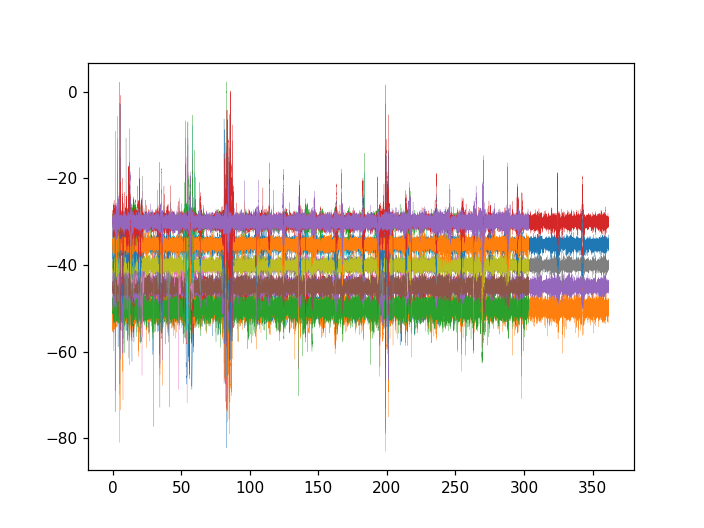

In [136]:
%matplotlib notebook

for i, (k, v) in enumerate(lfp_data.items()):
    for e in epoch_list:
        plt.plot((np.array(lfp_timestamp.get(e))-np.array(lfp_timestamp.get(e))[0])/fs_time,
                 np.array(v.get(e))/1000+5*(i-10), lw=.15)

### Import DIO data

In [137]:
# Load DIO
%matplotlib notebook

plot_DIO = False

filter_retrigger = 0

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=5)
tick_minutes_fmt = mdates.DateFormatter('%H:%M')
tick_minor = mdates.SecondLocator(interval=10)

# Specify parameters
dict_sensor_pump_map = {2: {'pump': 'laser_pump'},
                        # 6: {'sensor': 'reward_1_sensor'},
                        5: {'sensor': 'reward_1_sensor'},
                       }

# list dio to extract
list_dio = [2, 5]
y_label = ['laser',
           'reward 1',]

# plot each session
# get data for each animal
# initiate output
dict_dio_out = {}

dict_dio_in = {}

for animal_id in ['clc', ]:
    
    print(animal_id)
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all,
                                        experiment_name, trodes_version=2)
    cls_behavior.filter_animals(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    
    if not dict_rewards:
        continue
        
    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False,
                                                   output_raw=False,
                                                   filter_retrigger=None)
    
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False,
                                             output_raw=False,
                                             filter_retrigger=None)
    
    # get unique sessions
    sessions_unique = np.sort(df_sensor['session'].unique())
    print(sessions_unique)
    n_subplots = len(sessions_unique)
    
    if plot_DIO:
        fig = plt.figure(figsize=(10, n_subplots*3+2))
        axs = fig.subplots(n_subplots, 1)
        if n_subplots == 1:
            axs = [axs, ]
            sessions_unique = [sessions_unique[0], ]
    
    else:
        axs = [0]*len(sessions_unique)
    
    # divide into sessions
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):
        # get session times
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        # get sensor and pump times
        df_sensor_curr = df_sensor[df_sensor['session']==session]
        df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start)
                                       & (df_sensor_curr['on_time_sys']<curr_end)]
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start)
                                       & (df_pump_curr['on_time_sys']<curr_end)]
        dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
        dict_dio_in.update({int(session.split('_')[1]): df_sensor_curr})
        
        if not plot_DIO:
            continue
        
        # plot DIO data for all sessions
        for i, d in enumerate(list_dio):
            #print(d)
            yval = i+1
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
            df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]
            # plot well triggers
            
            for ind, row in df_plot_sensor.iterrows():
                ax.scatter(row['on_time_sys'], yval+.3, s=25, c='k')
                
            for ind, row in df_plot_pump.iterrows():
                
                try:
                    ax.plot([row['on_time_sys'],
                              row['off_time_sys']], [yval+.15, yval+.15], c='r')
                
                except:
                    pass

clc
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
/media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_01_stim.DIO/20220622_6082737_01_stim.dio_ECU_Din4.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
/media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_02_stim.DIO/20220622_6082737_02_stim.dio_ECU_Din4.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time


no dataframe created - data not suitable
no dataframe created - data not suitable
/media/nvme0/Data/6082737/preprocessing/20220622/20220622_6082737_03_stim.DIO/20220622_6082737_03_stim.dio_ECU_Din4.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
['20220622_01' '20220622_02' '20220622_03']


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time


In [138]:
stim_time_dict = {}
for item in dict_dio_out.items():
    df_pump_curr = item[1]
    key_curr = item[0]
    for i, d in enumerate(list_dio):
        # extract the wanted DIO data
        try:
            df_pump_timestamp = np.array(df_pump_curr[df_pump_curr['dio_bit']=='ECU_Dout2'].get('on_time'))
            df_pump_time = (df_pump_timestamp - time_dict.get(key_curr).get('timestamp')[0])/fs_time
            stim_time_dict.update({item[0]:{'timestamp':df_pump_timestamp,'time':df_pump_time}})
        except AttributeError:
            pass

## Raw data inspection

In [178]:
### simulate what happens online (stepwise filtering) ###

def generate_matrix(regr_buffer_size):
    sampling_axis = np.arange(regr_buffer_size)
    A = np.vstack([sampling_axis, np.ones(len(sampling_axis))]).T
    return A


def calculate_derv(A, buffer):
    curr_regr = buffer[:, np.newaxis]
    pinv = np.linalg.pinv(A)
    alpha = pinv.dot(curr_regr)
    return alpha[0][0]


def derivative_history(butter_filter, raw_data, fltr_buffer_size, regr_buffer_size):
    derivative_history = []
    A = generate_matrix(regr_buffer_size)
    
    for i in range(fltr_buffer_size, len(raw_data)):
        curr_buffer = raw_data[i-fltr_buffer_size:i]
        curr_filtered = sosfiltfilt(butter_filter, curr_buffer)
        curr_derv = calculate_derv(A, curr_filtered[-regr_buffer_size:])
        
#         curr_buffer = raw_data[i-regr_buffer_size:i]
#         curr_derv = calculate_derv(A, curr_buffer)
#         derivative_history.append(curr_derv)
        
    return derivative_history


def critical_point(derivative_history, time, regr_buffer_size, which, num_to_wait=5):
    critical_index = []
    critical_time = []
    current_sign = True
    sign_buffer = []

    for i in range(len(derivative_history)):
        if i == 0:
            current_sign = (derivative_history[0]>0)
            sign_buffer = [derivative_history[0]>0]*num_to_wait
            continue

        sign_buffer.append(derivative_history[i]>0)
        sign_buffer.pop(0)

        flip = True
        for sign in sign_buffer:
            if current_sign == sign:
                flip = False
                break
        
        if flip:
            current_sign = sign_buffer[-1]
            if which:
            # which == True means you want the peaks
                if (not current_sign) and index_in[i+int(regr_buffer_size/2)-num_to_wait]:
                    # at peaks, current_sign already flipped to be false
                    critical_index.append(i+int(regr_buffer_size/2)-num_to_wait)
                    critical_time.append(time[i+int(regr_buffer_size/2)-num_to_wait])
            else:
            # otherwise you want the troughs
                if current_sign and index_in[i+int(regr_buffer_size/2)-num_to_wait]:
                    # at troughs, current_sign flipped to be true
                    critical_index.append(i+int(regr_buffer_size/2)-num_to_wait)
                    critical_time.append(time[i+int(regr_buffer_size/2)-num_to_wait])
    
    return np.array(critical_index), np.array(critical_time)

In [179]:
online_peaks = critical_point(derivative_history(butter(1, [4, 10], 'bp', fs=fs_filter, output='sos'), raw, 400, 50),
                              time, 50, False, num_to_wait=3)

# online_peaks = critical_point(derivative_history(butter(1, [4, 10], 'bp', fs=fs_filter, output='sos'), filtered, 400, 50),
#                               time, 50, True, num_to_wait=3)

In [141]:
def index_in(butter_filter, raw_data, num_std=0):
    filtered_data = sosfiltfilt(butter_filter,raw_data)
    filtered_envelope = np.abs(hilbert(filtered_data))
    bar = np.mean(filtered_envelope) + num_std*np.std(filtered_envelope)
    index_in = np.array(filtered_envelope) > bar
    return index_in


def select_target(filtered_data, time, target, index_in, error_bound=0.0015):
    
    ## PROBLEM: need to use index_in together with peaks index array ##
    
    if target == np.pi:
        
        # peaks, _ = signal.find_peaks(filtered, height=0)
        # target_index = peaks[index_in]
        target_index, _ = signal.find_peaks(filtered, height=0)
        target_time = time[target_index]
        
    elif target == 0:
        
        # find trough = flip the sign of the whole array and
        # find peak
        # troughs, _ = signal.find_peaks(-filtered, height=0)
        # target_index = troughs[index_in]
        target_index, _ = signal.find_peaks(-filtered, height=0)
        target_time = time[target_index]
    
    else:
        
        df_phase = pd.DataFrame({"phase":np.angle(hilbert(filtered_data)) + np.pi, 
                                 "time":time, "index_in":index_in})
        selected_targets = df_phase[(np.abs(df_phase["phase"]-target) <= error_bound) & 
                                     df_phase['index_in']]
        target_index = np.array(selected_targets.index)
        target_time = np.array(selected_targets["time"])
        
    return target_index, target_time


def calculate_accuracy(target_time, hardware_on_time, window=0.060):
    # find the timepoint when detection started
    detection_start = np.searchsorted(np.array(target_time) - hardware_on_time[0], [0])[0]
    target_time = target_time[detection_start:]
    
    # determine if there's a stim event within window time around phase target
    hit = []
    for target in target_time[detection_start:]:
        for i in range(len(hardware_on_time)):
            if 0 <= (hardware_on_time[i]-target) <= window:
                hit.append(hardware_on_time[i])
                break

    return np.array(hit), len(hit)/len(target_time[detection_start:])


def calculate_precision(target_time, hardware_on_time, window=0.060):
    # find the timepoint when detection started
    detection_start = np.searchsorted(np.array(target_time) - hardware_on_time[0], [0])[0]
    target_time = target_time[detection_start:]
    
    # determine if there's a phase target within window time around stim
    precise = []
    for hardware in hardware_on_time:
        for target in target_time[detection_start:]:
            if 0 <= (hardware-target) <= 0.100:
                precise.append(hardware_on_time[i])
                break
 
    return precise, len(precise)/len(hardware_on_time)


def replace_with_nearest(lst1, lst2):
    '''
    replace lst1 elements with their nearest elements
    in lst2
    '''
    return lst2[[np.abs(lst2 - e).argmin() for e in lst1]]

In [168]:
target_lowcut = 4
target_highcut = 10
buffer_size = 200

# session_target_map = {1:0,
#                       2:np.pi,
#                       3:np.pi/2,
#                       4:3*np.pi/2}

# session_target_map = {1:np.pi/2,
#                       2:3*np.pi/2,}

# session_target_map = {1:np.pi,
#                       2:np.pi,
#                       3:np.pi}

# session_target_map = {1:np.pi,
#                       2:np.pi,
#                       3:np.pi,
#                       4:np.pi,}

# session_target_map = {1:np.pi,
#                       2:np.pi,
#                       3:np.pi,
#                       4:np.pi,
#                       5:np.pi,
#                       6:np.pi}

session_target_map = {1:np.pi,
                      2:0,
                      3:0,}

tetrode = 20
session = 3

butter_filter = butter(1, [target_lowcut, target_highcut], 'bp', fs=fs_filter, output='sos')
raw = lfp_data[tetrode][session]
filtered = sosfiltfilt(butter_filter, raw)

# LFP time
time = time_dict.get(session).get('time')
timestamp = time_dict.get(session).get('timestamp')

# stim time
stim_time = stim_time_dict.get(session).get('time')
stim_timestamp = replace_with_nearest(stim_time_dict.get(session).get('timestamp'), 
                                      time_dict.get(session).get('timestamp'))

In [169]:
# identify stim periods
stim_pivots = np.where(np.diff(np.append(-19, stim_time)) > 1)[0][1:]
stim_timestamp_cut = np.split(stim_timestamp, stim_pivots)
stim_start = np.array([s[0] for s in stim_timestamp_cut])
stim_end = np.array([s[-1] for s in stim_timestamp_cut])

### offline simulation

### Identify phase targets

In [170]:
# power_bar - only consider periods of considerable theta power
power_bar = False

if power_bar:
    index_in = index_in(butter_filter, raw)
else: 
    index_in = [True]*len(raw)

target_index, target_time = select_target(filtered, time, session_target_map.get(session), index_in)

# select targets in the stim periods
real = np.isin(time_dict.get(session).get('timestamp')[target_index],
               np.hstack([np.linspace(start, end, (end-start+1))
                          for start, end in zip(stim_start, stim_end)]))

target_index = target_index[real]
target_time = target_time[real]

### Visualize LFP and stim (and simulated signal)

<IPython.core.display.Javascript object>


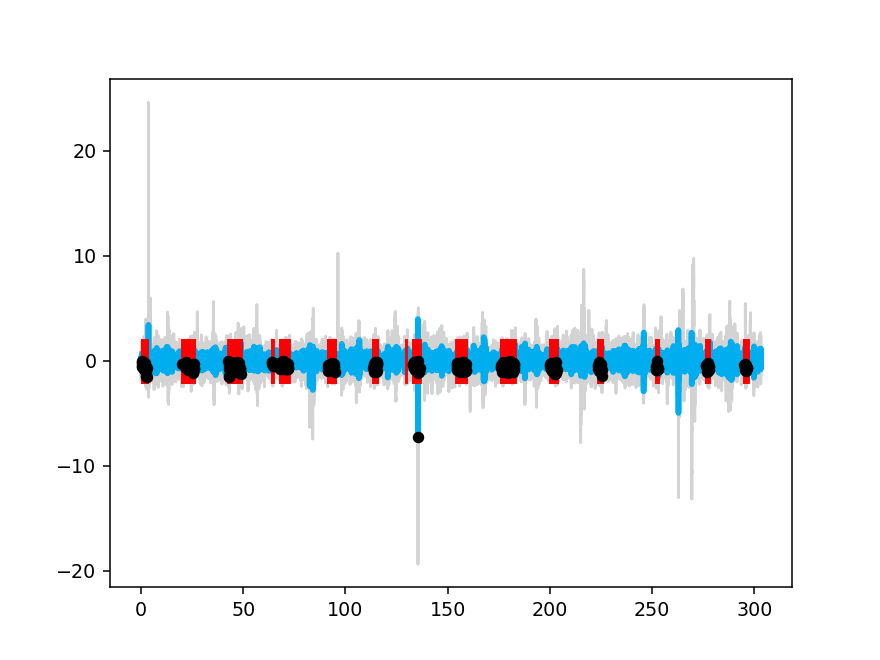

IndexError: arrays used as indices must be of integer (or boolean) type

In [180]:
# visualize LFP, targets, and stims
%matplotlib notebook

filtered = sosfiltfilt(butter_filter, raw)

# raw signal
plt.plot(time_dict.get(session).get('time'), raw/1000, c='lightgray', label='Raw')

# filtered signal
plt.plot(time_dict.get(session).get('time'), filtered/1000, lw=3, color='#00AEEF', label='6-10Hz')

# stimulation events
for on_time in stim_time:
    plt.plot([on_time, on_time], [-2, 2], c='r', lw=1.5)

# targets
plt.scatter(target_time, (filtered/1000)[target_index],
            c='k', s=25, zorder=3, label='target')

# online-simulatioon detected peaks
plt.scatter(online_peaks[1], (filtered/1000)[online_peaks[0]], c='orange', s=25, zorder=3)

plt.xlabel('Time (s)')
plt.ylabel('Signal (uV)')
plt.title(f'{choose_dates[0]} session {session}')

In [146]:
### inspect good detection cycles and bad detection cycles respectively ###

win_size_time = 140 # in ms
win_size_timestamp = win_size_time*(10**(-3))*fs_time

df_cycles = pd.DataFrame({# 'start_idx':[],
                          # 'start_timestamp':[],
                          # 'end_idx':[],
                          # 'end_timestamp':[],
                          'stim_time_aligned':[],
                          'stim_time_real':[],
                          'stim_count':[],
                          'win_time':[],
                          'raw':[],
                          'filtered':[]})

# use theta peaks as window bounds
for i, t in enumerate(target_index):
    
    try:
    
        # the last target in each bout doesn't start a cycle
        if target_time[i+1] - target_time[i] > 5:
            continue

        # real stim time
        stim_time_real = stim_time[((stim_timestamp > timestamp[t])
                                      &(stim_timestamp < timestamp[target_index[i+1]]))]
        # relative stim time in milliseconds aligned to theta peak
        stim_time_aligned = (stim_time_real - time[t])*1000
        # relative window time axis - for plotting
        win_time_aligned = (time[t:target_index[i+1]] - time[t])*1000

        df_cycles = df_cycles.append({# 'start_idx':t,
                                      # 'start_timestamp':timestamp[t],
                                      # 'end_idx':target_index[i+1],
                                      # 'end_timestamp':timestamp[target_index[i+1]],
                                      'stim_time_aligned':stim_time_aligned,
                                      'stim_time_real':stim_time_real,
                                      'stim_count':len(stim_time_aligned),
                                      'win_time':win_time_aligned,
                                      'raw':raw[t:target_index[i+1]],
                                      'filtered':filtered[t:target_index[i+1]]},
                                      ignore_index=True)
        
    except IndexError:
        pass

### Compare good and bad cycles

In [147]:
# signal_type='raw'

# win_interp = np.linspace(0, 0.15, 300)
# group_1_interp = []
# group_2_interp = []

# for ind, row in df_cycles[df_cycles['stim_count']==1].iterrows():
    
# for s, t in zip(group_1.get(signal_type).tolist(), group_1.get('win_time').tolist())

# group_1_avg = np.average(group_1, axis=0)
# group_1_sem = stats.sem(group_1, axis=0)
# group_1_std = stats.tstd(group_1, axis=0)

# for ind, row in df_cycles[df_cycles['stim_count']!=1].iterrows():

# group_2 = df_cycles[df_cycles['stim_count']!=1].get(signal_type).tolist()
# group_2_avg = np.average(group_2, axis=0)
# group_2_sem = stats.sem(group_2, axis=0)
# group_2_std = stats.tstd(group_2, axis=0)

<IPython.core.display.Javascript object>


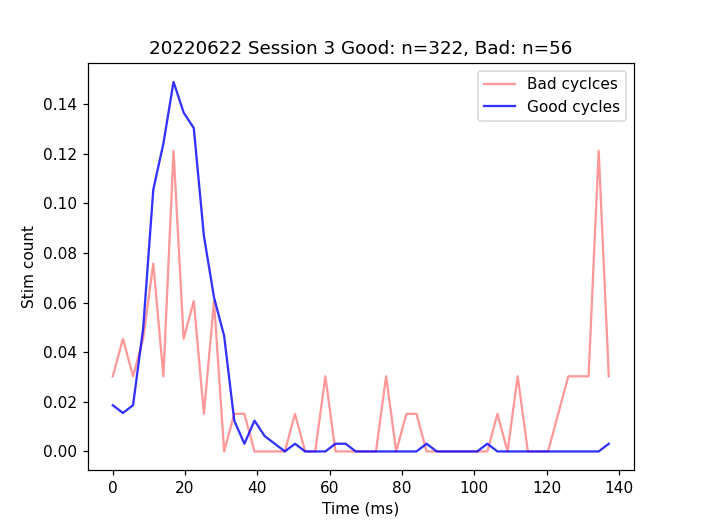

Text(0.5, 1.0, '20220622 Session 3 Good: n=322, Bad: n=56')

In [148]:
%matplotlib notebook

good_cycles = df_cycles[df_cycles['stim_count']==1]
bad_cycles = df_cycles[df_cycles['stim_count']!=1]

# stim distribution
stim_good_hist, stim_good_edges = np.histogram(np.hstack(good_cycles.get('stim_time_aligned').tolist()), 
                                               bins=50, range=(0,140))

stim_bad_hist, stim_bad_edges = np.histogram(np.hstack(bad_cycles.get('stim_time_aligned').tolist()), 
                                               bins=50, range=(0,140))

plt.plot(stim_bad_edges[:-1], stim_bad_hist/sum(stim_bad_hist), color='r', alpha=0.4, label='Bad cyclces')
plt.plot(stim_good_edges[:-1], stim_good_hist/sum(stim_good_hist), color='b', alpha=0.8, label='Good cycles')

# plt.plot(stim_good_edges[:-1], stim_good_hist/sum(stim_good_hist), color='b', alpha=0.4)
# plt.plot(stim_bad_edges[:-1], stim_bad_hist/sum(stim_bad_hist), color='r', alpha=0.4)
# plt.plot(stim_good_edges[:-1], stim_good_hist, color='b', alpha=0.4)
# plt.plot(stim_bad_edges[:-1], stim_bad_hist, color='r', alpha=0.4)

# shrink_factor = 10

# plt.plot(np.linspace(0, win_size_time, len(group_1_avg)), group_1_avg/shrink_factor, c='b')
# plt.fill_between(np.linspace(0, win_size_time, len(group_1_avg)),
#                  (group_1_avg + group_1_sem)/shrink_factor,
#                  (group_1_avg - group_1_sem)/shrink_factor,
#                  alpha=0.4, label='Good', color='b')

# plt.plot(np.linspace(0, win_size_time, len(group_2_avg)), group_2_avg/shrink_factor, c='r')
# plt.fill_between(np.linspace(0, win_size_time, len(group_2_avg)),
#                  (group_2_avg + group_2_sem)/shrink_factor,
#                  (group_2_avg - group_2_sem)/shrink_factor,
#                  alpha=0.4, label='Bad', color='r')

plt.legend()
plt.xlabel('Time (ms)')
# plt.ylabel('Signal (uV)')
plt.ylabel('Stim count')
plt.title(f'{choose_dates[0]} Session {session} Good: n=%d, Bad: n=%d' %(len(good_cycles), len(bad_cycles)))
# plt.savefig(f"{dir_fig}{choose_dates[0]}_{experiment_name}_session{session}_stim_time_hist.png")

In [149]:
# %matplotlib notebook

# # signal_type = 'raw'
# signal_type = 'filtered'
# # shrink_factor = 50
# offset = 1000

# for ind, row in df_cycles.iterrows():
#     if row['stim_count'] == 1:
#         plt.plot(np.linspace(0, win_size_time, len(row[signal_type])), 
#                  row[signal_type]/shrink_factor+offset, c='b', alpha=0.1)
#         # pass
#     else:
#         plt.plot(np.linspace(0, win_size_time, len(row[signal_type])), 
#                  row[signal_type]/shrink_factor+2*offset, c='r', alpha=0.1)
#         # pass

# # stim distribution
# plt.plot(stim_bad_edges[:-1], 10000*stim_bad_hist/sum(stim_bad_hist), 
#         color='r', alpha=0.4, label='Bad Stim')
# plt.plot(stim_good_edges[:-1], 10000*stim_good_hist/sum(stim_good_hist), 
#         color='b', alpha=0.8, label='Good Stim')

# plt.plot([0],[0],c='b',label='Good Cycles')
# plt.plot([0],[0],c='r',label='Bad Cycles')
# #b plt.legend()
# plt.xlabel('Time (ms)')
# plt.ylabel('Signal (uV)')

### Signal aligned to stim event groups

In [150]:
def align_to_events_continuous(data_in, times_in, ref_events, win):
    """
    Aligns a continuous data to reference events.
    Example usage: align LFP relative to known events.
    All event times are in seconds

    :param data_in: array of values (LFP signal)
    :param times_in: array of timestamps for values
    :param ref_events: array of event times to align to
    :param win: window length around alignment time in seconds
    :return: array of event values and times aligned to ref_events
    """

    arr_out_data = []
    arr_out_time = []

    for e in ref_events:

        # get time indices around window
        try:
            ind_start = np.argmax(times_in >= e - win)
            ind_end = np.argmax(times_in >= e + win)
            data_incl = data_in[ind_start:ind_end]
            time_incl = times_in[ind_start:ind_end] - e
            arr_out_data.append(data_incl)
            arr_out_time.append(time_incl)
        except:
            print(f'{e} failed')

    return arr_out_data, arr_out_time


In [167]:
### good stim - CONTROL group - only one good stim in cycle ###
good_stim_real = np.hstack(df_cycles[df_cycles['stim_count']==1].get('stim_time_real'))
good_stim_aligned = np.hstack(df_cycles[df_cycles['stim_count']==1].get('stim_time_aligned'))
good_stim = good_stim_real[good_stim_aligned < 60]
# good_stim = np.hstack(df_cycles[df_cycles['stim_count']==1].get('stim_time_real'))

### off stim - stim events delayed to opposite phase ###
off_stim = np.hstack(df_cycles.get('stim_time_real'))[np.hstack(df_cycles.get('stim_time_aligned')) > 60]

### double stim - first ones and second ones ###
double_stim = np.hstack(df_cycles[df_cycles['stim_count']==2].get('stim_time_real'))
first_stim = double_stim[::2]
second_stim = double_stim[1::2]

print(f'{len(good_stim)*100/len(stim_time):.2f}% good events, {len(off_stim)*100/len(stim_time):.2f}% off events, '\
      f'{len(first_stim)*100/len(stim_time):.2f}% double-stim events')

72.21% good events, 11.39% off events, 7.74% double-stim events


In [154]:
stim_group_dict = {}

win_size = 0.1
tvals = np.linspace(-win_size, win_size, 300)

# for s_t, n in zip([good_stim, off_stim, first_stim, second_stim],
#                   ['good', 'off', 'first', 'second']):

# for s_t, n in zip([off_stim], ['off']):

for s_t, n in zip([good_stim, first_stim, second_stim],
                  ['good', 'first', 'second']):
    
    raw_stim, time_stim = align_to_events_continuous(raw, time, s_t, win_size)
    filtered_stim, _ = align_to_events_continuous(filtered, time, s_t, win_size)
    
    raw_interp = []
    filtered_interp = []
    for r, f, t in zip(raw_stim, filtered_stim, time_stim):

        try:
            raw_interp.append(np.interp(tvals, t, r))
            filtered_interp.append(np.interp(tvals, t, f))

        except ValueError:
            pass
    
    stim_group_dict.update({n:{
        'raw_interp':raw_interp,
        'filtered_interp':filtered_interp,}})

<IPython.core.display.Javascript object>


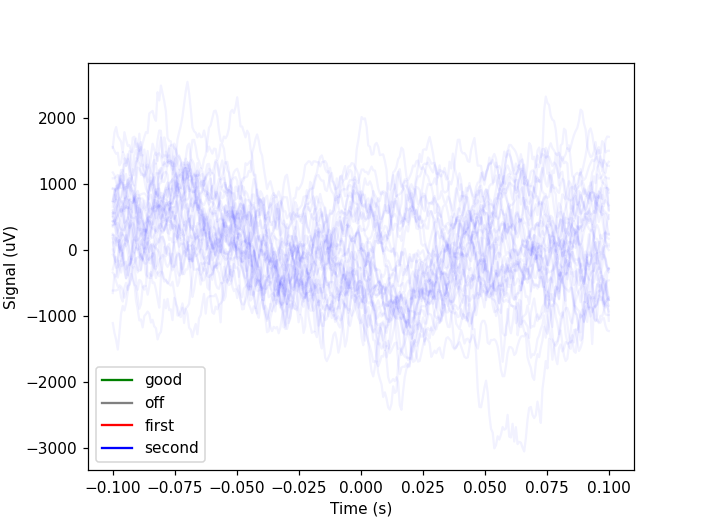

Text(0, 0.5, 'Signal (uV)')

In [155]:
%matplotlib notebook

group_color_map = {'good':'green',
                   'off':'gray',
                   'first':'red',
                   'second':'blue'}

signal_type = 'raw'
# signal_type = 'filtered'

for n, s_g in stim_group_dict.items():
    
    if n != 'second':
        continue
    
    curr_color = group_color_map.get(n)
    
    for s in s_g.get(signal_type+'_interp'):
        
        plt.plot(tvals, s, c=curr_color, alpha=0.05)

for n, color in group_color_map.items():
    plt.plot([0], [0], c=color, label=n)
        
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Signal (uV)')

<IPython.core.display.Javascript object>


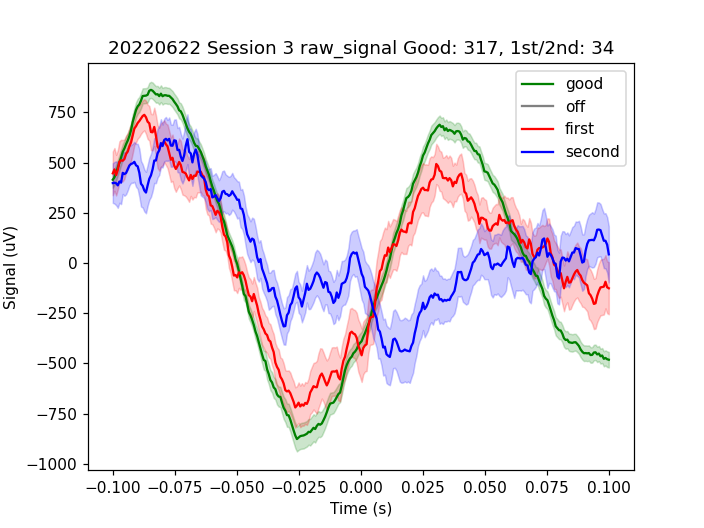

Text(0, 0.5, 'Signal (uV)')

In [156]:
%matplotlib notebook

for n, s_g in stim_group_dict.items():

    curr_color = group_color_map.get(n)
    # avg = np.median(s_g.get(signal_type+'_interp'), axis=0)
    avg = np.average(s_g.get(signal_type+'_interp'), axis=0)
    sem = stats.sem(s_g.get(signal_type+'_interp'), axis=0)
    plt.plot(tvals, avg, c=curr_color)
    plt.fill_between(tvals, avg-sem, avg+sem, color=curr_color, alpha=0.2)

for n, color in group_color_map.items():
    plt.plot([0], [0], c=color, label=n)

plt.legend()
plt.title(f'{choose_dates[0]} Session {session} {signal_type}_signal Good: {len(good_stim)}, 1st/2nd: {len(first_stim)}')
plt.xlabel('Time (s)')
plt.ylabel('Signal (uV)')
# plt.savefig(f"{dir_fig}{choose_dates[0]}_{experiment_name}_session{session}_stim_event_group_curve.png")

### Accuracy and Precision

In [157]:
hit, accuracy = calculate_accuracy(target_time, stim_time)
precise, precision = calculate_precision(target_time, stim_time)
print(f'Detection accuracy {accuracy*100:.2f}%, precision {precision*100:.2f}%')

Detection accuracy 94.64%, precision 86.33%


### Lag

<IPython.core.display.Javascript object>


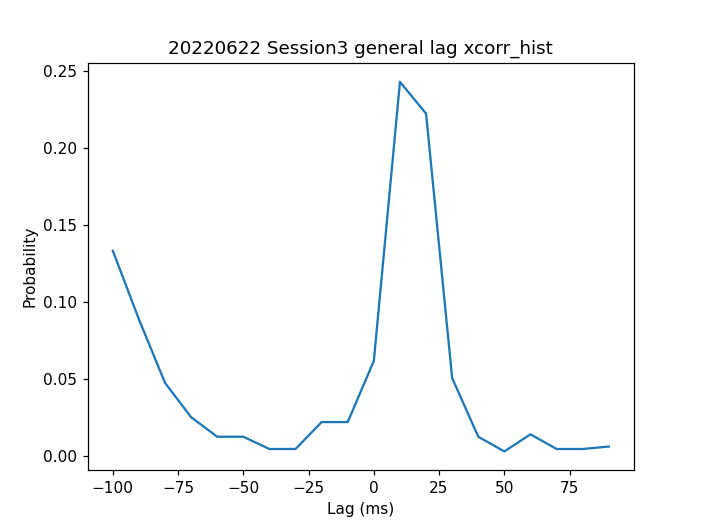

Text(0.5, 1.0, '20220622 Session3 general lag xcorr_hist')

In [158]:
# analyze general lag
%matplotlib notebook

on_lag_hist, on_lag_edges = np.histogram(np.hstack([stim - target_time for stim in stim_time])*1000, 
                                         bins=20, range=(-100,100))

plt.plot(on_lag_edges[:-1],
         on_lag_hist/sum(on_lag_hist),)

plt.ylabel('Probability')
plt.xlabel('Lag (ms)')
plt.title(f'{choose_dates[0]} Session{session} general lag xcorr_hist')
# plt.savefig(f"{dir_fig}{choose_dates[0]}_{experiment_name}_session{session}_general_lag.png")

## LFP signal analysis
### determine frequency composition of movement artifact

<IPython.core.display.Javascript object>


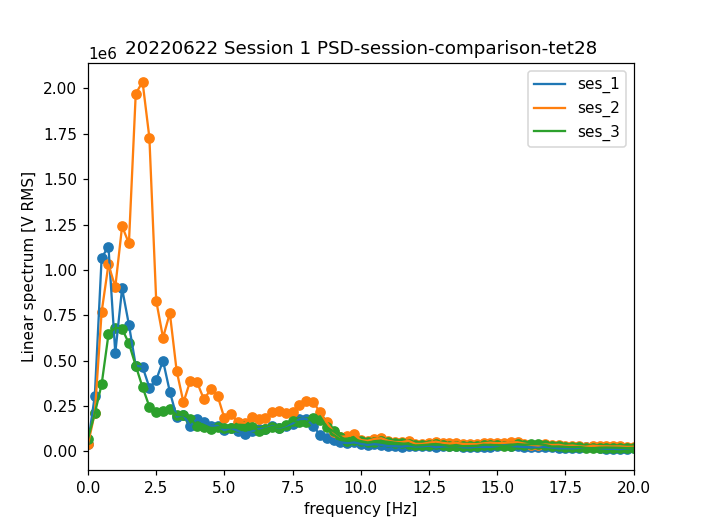

<IPython.core.display.Javascript object>


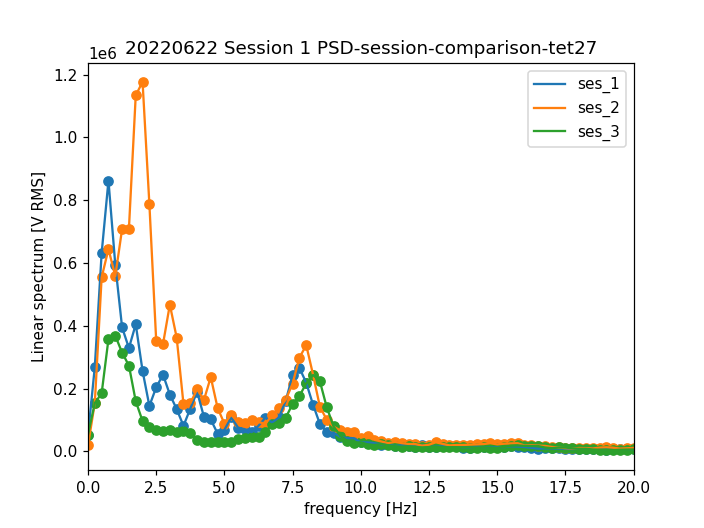

<IPython.core.display.Javascript object>


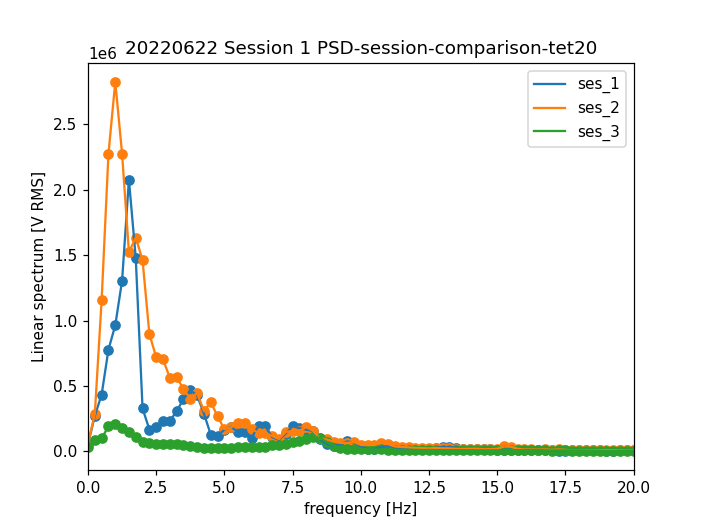

<IPython.core.display.Javascript object>


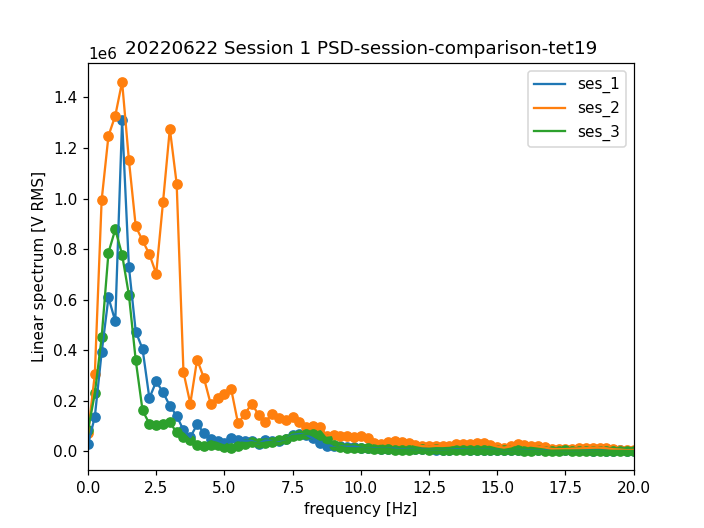

<IPython.core.display.Javascript object>


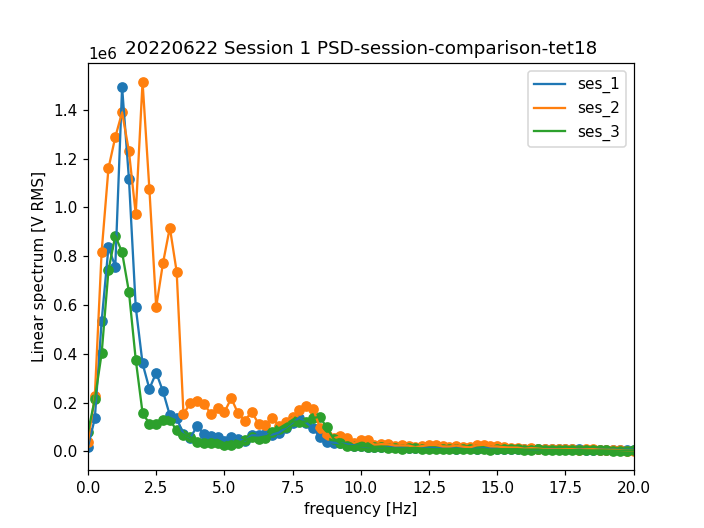

In [28]:
%matplotlib notebook

fs = 1500

# for e in epoch_list:
#     for t in tet_list:
for t in tet_list:
    # for e in epoch_list:
    plt.figure()
    for e in [1,2,3,]: 
        # plt.figure()
        
        # f, Pxx_spec = signal.welch(stim_period_only, fs, nperseg=fs, noverlap=fs/2)
        # f, Pxx_spec = signal.welch(raw, fs, nperseg=4*fs, noverlap=fs/2)
        f, Pxx_spec = signal.welch(lfp_data.get(t).get(e), fs, nperseg=4*fs, noverlap=fs/2)
        
        plt.scatter(f, Pxx_spec)
        plt.plot(f, Pxx_spec, label=('ses_%d'%e))
        # plt.scatter(f, np.sqrt(Pxx_spec))
        # plt.plot(f, np.sqrt(Pxx_spec))
        
        plt.legend()
        plt.xlabel('frequency [Hz]')
        plt.ylabel('Linear spectrum [V RMS]')
        plt.xlim([0, 20])
        
        # title = 'PSD-session%d-tet%d' %(e,t)
        # title = 'PSD-session-comparison-tet%d' %t
        plt.title(f'{choose_dates[0]} Session {session} PSD-session-comparison-tet{t}')                                                                                                                                                                                                                                                                                                                    
        # plt.savefig(f"{dir_fig}{choose_dates[0]}_{experiment_name}_PSD_session_comparison_tet{t}.png")

In [152]:
# wavelet transform

fs = 1500

wave_scale = np.arange(1, 500)
wave_type = 'morl'
#wave_type = 'gaus1'
wave_type = 'cmor2.0-1.0' # best option?

dict_wave_out = {}

for i, (k, v) in enumerate(lfp_data.items()):
    
    if k != 20:
        continue
    
    for e in [5,]:
        ts_scaled = lfp_timestamp
#        index_values = find_ind(select_index, ts_scaled)
        
#         curr_lfp = v[index_values[0]:index_values[1]]
#         curr_lfp_time = lfp_timestamp[index_values[0]:index_values[1]]
        
        curr_lfp = v.get(1)
        curr_lfp_time = lfp_timestamp
        
        coef, freq = pywt.cwt(curr_lfp, 
                              wave_scale, wave_type, sampling_period=1/fs, method='fft')
        
        coef_m = (abs(coef))**2

        curr_coef_m = np.mean(coef_m, axis=1)
        curr_coef_sd = np.std(coef_m, axis=1)
        curr_coef_z = (coef_m-curr_coef_m[:, None])/curr_coef_sd[:, None]
        
        dict_wave_out.update({k: {'coef': coef,
                                  'freq': freq,
                                  'coef_power': coef_m,
                                  'lfp': curr_lfp,
                                  'mean': curr_coef_m,
                                  'std': curr_coef_sd,
                                  'coef_power_z': curr_coef_z,
                                  'lfp_timestamp': curr_lfp_time

                                 }
                             }
                            )
# sort by value        
dict_wave_out_sort_key = sorted(dict_wave_out.keys())


<IPython.core.display.Javascript object>


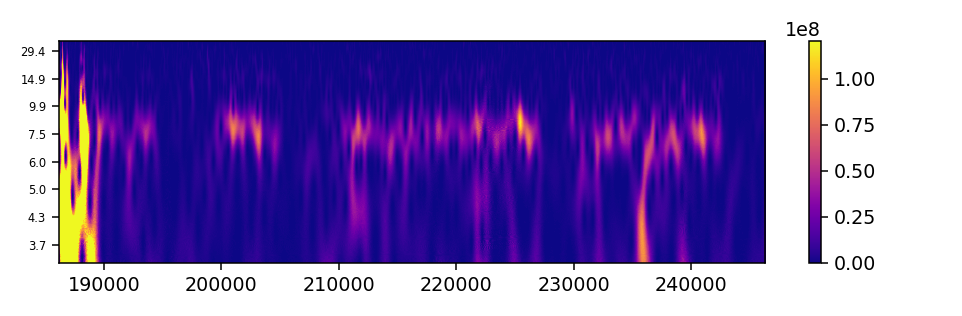

0 20


In [159]:
# axis_lim = select_index + [len(freq), 0]
# print(axis_lim)

plotz = False

nplots = 1
fig, ax = plt.subplots(nplots, 1, figsize=(7, 1+nplots*1.3),sharex=True, sharey=True)

for i, k in enumerate(dict_wave_out_sort_key):
    print(i, k)
    #if k == 26:
    #    continue

    #plt.figure(figsize=(10, 2))
    if plotz:
        curr_img_m = np.abs(dict_wave_out[k].get('mean'))
        curr_img_sd = np.abs(dict_wave_out[k].get('std'))

        curr_img = (np.abs(dict_wave_out[k].get('coef_power_z')))
        vmax = 3
        vmin = -1
        cmap = 'plasma'
    
    else:
        curr_img = np.abs(dict_wave_out[k].get('coef_power'))
        vmax = np.max(curr_img)*0.1
        vmin = 0
        cmap = 'plasma'

    curr_im = ax.imshow(curr_img, interpolation='nearest', aspect='auto', 
                   origin='upper', cmap=cmap, vmin=vmin, vmax=vmax)
    
    curr_lfp_timestamp = dict_wave_out[k].get('lfp_timestamp')
    curr_lfp = dict_wave_out[k].get('lfp')

    yticks = np.flip(wave_scale[::50]-1)

    ytick_label = [f'{i:.1f}' for i in freq[yticks]]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_label[::1], fontsize=6)
    plt.colorbar(curr_im, ax=ax)
    
#     ax[i].set_ylabel(f'tet {k}\n{tet_map.get(k)}\nf (Hz)', fontsize=6)
    
#     curr_lfp = dict_wave_out[k].get('lfp')
    ax.set_ylim(len(freq), 1)
#     ax[i].set_xlim(*select_index)
#     ax[i].plot(curr_lfp_timestamp, curr_lfp/25 + len(freq)-100, lw=.5, c='w')
# #     #ax[i-1].set_title(k)

plt.tight_layout()
#print(plt.gca().get_ylim())

# fname = f'{fname_exp}_file{f_choose}_{select_index[0]}_{select_index[1]}.pdf'
# fpath = f'{fig_dir}{fname}'

# plt.savefig(fpath)